In [1]:
import numpy as np

""" Import the classifier """
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

""" Helper function """
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

""" Metrics """
from sklearn.metrics import precision_score

""" SHAP Framework for feature contribution XAI """
import shap
shap.plots.initjs()

In [2]:
""" Create synthetic data """
X, y = make_classification(n_samples=400, n_features=5, n_informative=4, n_redundant=1, n_clusters_per_class=2, n_classes=5, random_state=42)

In [3]:
""" View the first row of X """
print(X[0,:])

[ 0.66149126  3.14710283 -5.0622089   1.81548833  2.18311506]


In [4]:
""" The class or label """
print(y)

[3 3 3 4 0 1 4 3 3 1 1 2 3 4 3 3 1 4 1 3 4 0 3 2 4 4 0 3 0 2 2 1 4 0 0 4 3
 4 2 0 3 1 1 4 0 2 3 1 1 1 0 3 3 3 1 4 3 1 0 4 1 3 4 4 1 4 1 1 2 3 3 3 0 0
 4 1 1 0 3 2 4 2 0 3 4 1 0 0 3 1 3 1 2 0 2 2 1 0 2 0 4 0 0 3 3 4 1 2 4 4 2
 0 3 0 0 1 3 2 4 0 3 2 2 2 0 1 1 2 1 4 0 1 3 2 4 2 3 0 3 2 4 1 0 0 2 3 4 1
 1 1 1 2 0 3 1 0 3 1 1 2 1 2 0 2 0 4 4 4 1 2 1 0 4 2 3 3 1 0 3 3 1 4 4 2 4
 2 0 2 4 4 3 1 1 2 2 2 1 1 2 3 1 2 1 0 1 2 0 4 4 4 2 0 0 4 2 4 1 1 2 0 3 0
 3 1 4 0 2 4 3 2 3 1 2 0 4 4 3 3 1 0 2 0 2 1 1 4 4 2 3 1 0 1 4 1 4 0 0 3 3
 2 3 1 0 3 0 3 1 0 1 0 3 0 3 3 0 0 2 4 4 4 4 2 2 4 1 4 2 0 4 0 4 0 4 4 1 0
 2 2 4 2 1 1 2 4 2 1 1 2 3 1 1 3 1 2 1 2 3 0 4 1 4 4 4 3 3 3 0 1 2 1 1 0 4
 0 4 2 3 2 4 3 4 0 0 4 0 0 4 0 0 1 3 2 1 0 2 4 2 2 3 0 3 0 0 2 2 1 0 4 0 2
 0 0 0 0 4 2 0 2 0 4 4 1 2 4 4 2 3 2 3 2 4 3 3 2 1 3 3 3 3 2]


In [38]:
""" The class for the model """
class Model:
    """ The models inside the dictionary datatype or a key-value pair data structure """
    MODELS_DICT = {
        'decision_tree': lambda random_state: DecisionTreeClassifier(random_state=random_state),      
        'logistic_reg': lambda random_state: LogisticRegression(random_state=random_state),          
        'random_forest': lambda random_state: RandomForestClassifier(random_state=random_state),      
        'hist_gradient_boost': lambda random_state: HistGradientBoostingClassifier(random_state=random_state), 
        'mlp': lambda random_state: MLPClassifier(random_state=random_state, max_iter=5000, solver='adam'),    
        'svc': lambda random_state: SVC(random_state=random_state, probability=True)                         
    }
    
    """ Explainer: 'tree'=TreeExplainer; 'kernel'=KernelExplainer """
    def __init__(self, data_X, data_y, model, explainer='tree', test_size=0.2, random_state=random_state):
        # print(data_X.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data_X, data_y, test_size=test_size, random_state=random_state)
        self.model = self.MODELS_DICT[model](random_state)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.explainer = self.select_explainer(explainer)
        self.shap_val_global = self.calculate_shap(self.X_test)
        shap.plots.initjs()
        # print(f'Y test shape: {self.y_test.shape}; Y test prediction shape: {self.y_test_pred.shape}:')

    def select_explainer(self, explainer):
        if explainer=='tree':
            self.explainer = shap.TreeExplainer(self.model)
        elif explainer=='kernel':
            K=100
            X_train_kmeans = shap.kmeans(self.X_train, K)
            self.explainer = shap.KernelExplainer(self.model.predict_proba, X_train_kmeans) #self.X_train
        return self.explainer

    def predict(self, new_data_X):
        return self.model.predict(new_data_X)

    def accuracy(self):
        return self.model.score(self.X_test, self.y_test)

    def precision(self, average='macro'):
        return precision_score(self.y_test, self.y_test_pred, average=average)

    def calculate_shap(self, data_X):
        return self.explainer.shap_values(data_X)

    def explain_local(self, data_X):
        shap_values = self.calculate_shap(data_X)
        # print(self.explainer.expected_value[0])
        # print(shap_values[0][0])
        # print(data_X[0])
        shap.force_plot(self.explainer.expected_value[0], shap_values[0][0], data_X[0], feature_names=[f"Feature {i+1}" for i in range(data_X.shape[1])])
        # shap.save_html("force_plot.html", force_plot)

    def explain_global(self):
        # print(self.shap_val_global[:,:])
        # print(f'Shap Value Shape: {self.shap_val_global[0].shape}; X Test Shape: {self.X_test.shape}')
        shap_values_mean = np.mean(self.shap_val_global, axis=0)
        shap.summary_plot(shap_values_mean, self.X_test, plot_type='bar')

    def get_model(self):
        return self.model


In [39]:
""" Unseen data: one row """
new_x = np.array([[0,1,0.5,2,0.3]])
new_x.shape

(1, 5)

### Below are the models in action 

Prediction: 3; Accuracy: 0.57; Precision: 0.57;


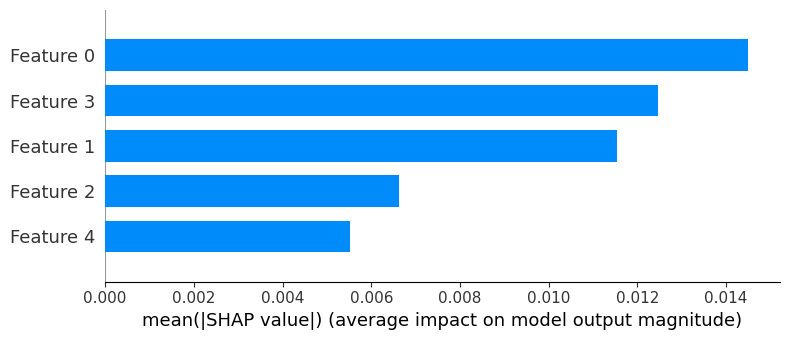

In [40]:
""" Decision Trees """
model = Model(X, y, model='decision_tree')
new_y = model.predict(new_x)
model.explain_local(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [41]:
model.explain_local(new_x)

In [42]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/80 [00:00<?, ?it/s]

Prediction: 4; Accuracy: 0.49; Precision: 0.51;


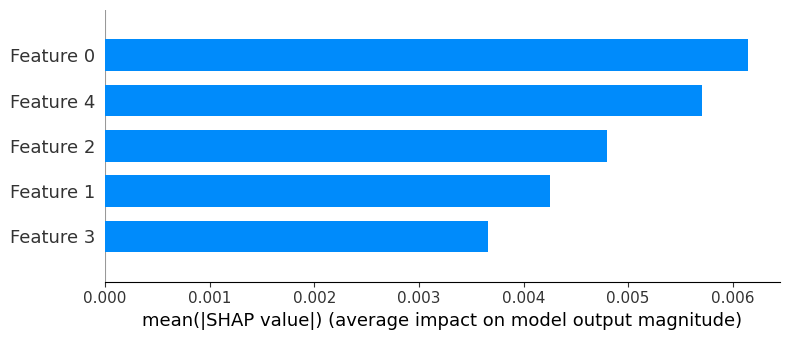

In [43]:
""" Logistic Regression """
model = Model(X, y, model='logistic_reg', explainer='kernel')
new_y = model.predict(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [44]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Prediction: 4; Accuracy: 0.65; Precision: 0.64;


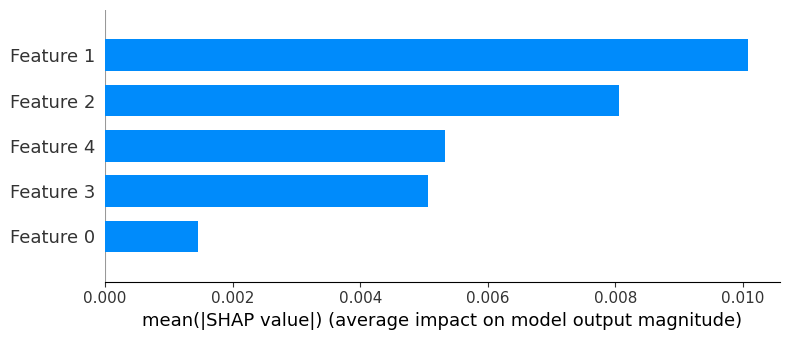

In [45]:
""" Random Forest """
model = Model(X, y, model='random_forest', explainer='kernel')
new_y = model.predict(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [46]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Prediction: 4; Accuracy: 0.59; Precision: 0.60;


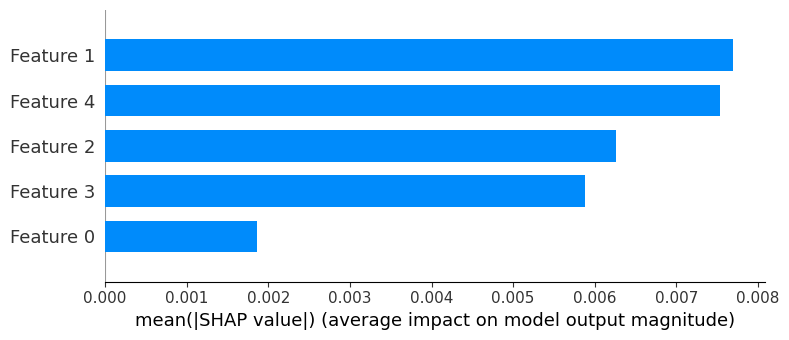

In [47]:
""" Support Vector Machine """
model = Model(X, y, model='svc', explainer='kernel')
new_y = model.predict(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [48]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/1 [00:00<?, ?it/s]

Prediction: 4; Accuracy: 0.61; Precision: 0.60;


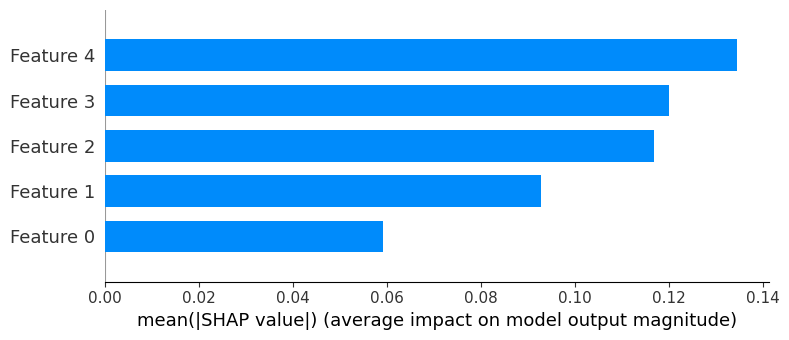

In [49]:
""" Gradient Boosting Machine Classifier """
model = Model(X, y, 'hist_gradient_boost')
new_y = model.predict(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [50]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/80 [00:00<?, ?it/s]

Prediction: 4; Accuracy: 0.66; Precision: 0.64;


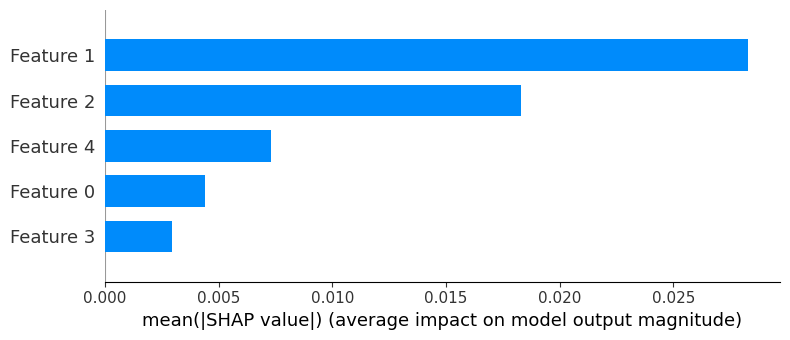

In [51]:
""" Multi-Layer Perceptron """
model = Model(X, y, model='mlp', explainer='kernel')
new_y = model.predict(new_x)
accuracy = model.accuracy()
print(f'Prediction: {new_y[0]}; Accuracy: {accuracy:.2f}; Precision: {model.precision():.2f};')
model.explain_global()

In [52]:
shap.force_plot(model.explainer.expected_value[0], model.calculate_shap(new_x)[0][0], new_x[0], feature_names=[f"Feature {i+1}" for i in range(new_x.shape[1])])

  0%|          | 0/1 [00:00<?, ?it/s]